In [1]:
# dataset
from torchvision import datasets

from functools import partial
import numpy as np
from copy import deepcopy

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# preprocessing
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

# model
import torch
from torch import nn
import torchvision.models as models
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# hyperparameter tuning
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 1. Load Data & Preprocessing

**Dataset**: <a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank">CIFAR-10</a>

**Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

The following transformations are used:
* **resize**
* **center crop**
* **normalization**: from [0, 255] to [0, 1]
* **standardization**: by substracting the mean and dividing with std according to ImageNet

In [2]:
def load_data(data_dir):
    """ Create train and test pytorch dataset objects from CIFAR-10.
    
    The following tranformations are applied on CIFAR-10:
        * resize images,
        * center crop images,
        * normalization: from [0, 255] to [0, 1] by dividing with 255,
        * standardization: by substracting the mean and dividing with std according to ImageNet
    
    Args:
        data_dir:
            directory where data will be saved, as a string.
    
    Returns:
        train and test dataset, as pytorch dataset objects.
    """
    transform = transforms.Compose([
        transforms.Resize(224), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    trainset = datasets.CIFAR10(root=data_dir,
                                train=True, 
                                download=True, 
                                transform=transform)

    testset = datasets.CIFAR10(root=data_dir, 
                               train=False, 
                               download=True, 
                               transform=transform)

    return trainset, testset

In [3]:
trainset, testset = load_data(data_dir='cifar10')

print(f'\nTraining data:\n--------------\n{trainset}')
print(f'Test data:\n--------------\n{testset}')

Files already downloaded and verified
Files already downloaded and verified

Training data:
--------------
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10-pytorch
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
--------------
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10-pytorch
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [4]:
batch_size = 64

train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# 2. ResNet-50

We'll use the **pretrained version** of ResNet-50. Since CIFAR-10 dataset has less classes than ImageNet, we'll keep all the layers **freezed**, except of the last one, which will be **unfreezed** and updated with the right number of classes and will be re-trained.

![ResNet](images\resnet.png)

Regularization:
* Weight decay (L2 regularization)

Loss Function:
* Cross Entropy Loss

Optimizer and Scheduler:
* Adam optimizer
* ReduceLROnPlateau scheduler

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    """ This helper function sets the .requires_grad attribute of the parameters in the model 
    to False when we are feature extracting. 
    
    When we are feature extracting and only want to compute gradients for the newly initialized layer, 
    then we want all of the other parameters to not require gradients.
    
    Args:
        model: 
            deep learning model, as pytorch object.
        feature_extracting:
            whether or not we're feature extracting, as boolean.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
def initialize_model(num_labels, feature_extracting, pretrained=True):
    """ Initialize ResNet-50 model and reshape the last layer with the correct number of classes.
    
    Since ResNet-50 has been pretrained on Imagenet, it has output layers of size 1000, one node for each class. 
    We reshape the last layer to have the same number of inputs as before, and to have the same number of 
    outputs as the number of classes in our the dataset.
    
    Args:
        num_labels:
            number of labels in our dataset, as integer.
        feature_extracting:
          flag for feature extracting (when False, we finetune the whole model, 
          when True we only update the reshaped layer params), as boolean.
        pretrained:
            whether or not we want the pretrained version of AlexNet, as boolean.
    
    Returns:
        ResNet-50 model, as pytorch object
    """
    model = models.resnet50(pretrained=pretrained)
    
    set_parameter_requires_grad(model, feature_extracting)
    
    last_layer_in_ftrs = model.fc.in_features
    model.fc = nn.Linear(last_layer_in_ftrs, num_labels)
    
    return model

# 3. Hyperparameter Tuning

We'll use **early stopping** with **ASHAScheduler** to stop bad trials earlier.

|                               | Validation Loss | Validation Accuracy |
| :---------------------------: | :-------------: | :-----------------: |
| ResNet-50                     | 0.44            | 84%                 |

Best trial **configuration** for ResNet-50: lr: 0.001, l2: 0.001

In [7]:
def tune_helper(config, trainset, num_labels, batch_size, epochs):
    """ Fit deep learning model and test it on a hold-out validation set.
    
    The validation set is a 20% hold-out set of the training set. 
    The loss function used is Cross Entropy Loss.
    The optimer used is Adam and the scheduler that wraps the optimizer is ReduceLROnPlateau.
    The metric used is accuracy score.
    
    Args:
        config:
            hyperparameters of neural network, as a dictionary.
        trainset:
            training dataset, as a pytorch object.
        num_labels:
            number of labels, as an integer.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
    """
    feature_extracting = True
    pretrained = True
    model = initialize_model(num_labels=num_labels, 
                             feature_extracting=feature_extracting, 
                             pretrained=pretrained)
    
    # support data parallel training on multiple GPUs
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    # create an optimizer that only updates the desired parameters
    params_to_update = model.parameters()
    print("Parameters to learn:")
    if feature_extracting:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                print("\t", name)
    
    # optimizer
    optimizer = AdamW(params_to_update, lr=config['lr'], weight_decay=config['l2'])
    
    #scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min')
    
    
    # loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # split data: training (80%) - validation (20%)
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    train_dataloader = DataLoader(train_subset,
                                  batch_size=batch_size,
                                  shuffle=True, 
                                  num_workers=2)
    
    val_dataloader = DataLoader(val_subset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2)
    
    for epoch in range(epochs):
        # fit neural network on training data
        model.train()  # put on train mode
        for batch, (X, Y) in enumerate(train_dataloader, 0):
            # send the data to the GPU memory explicitly
            X, Y = X.to(device), Y.to(device)

            # reset the gradients
            optimizer.zero_grad()
            
            # compute prediction
            pred = model(X)

            # compute loss
            loss = loss_fn(pred, Y)

            # backpropagate
            loss.backward()

            # update parameters
            optimizer.step()
        
        # test on validation data
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        model.eval()  # put on evaluation mode
        for batch, (X, Y) in enumerate(val_dataloader, 0):
            with torch.no_grad():
                X, Y = X.to(device), Y.to(device)

                pred = model(X)
                
                _, predicted = torch.max(pred.data, 1)
                total += Y.size(0)
                correct += (predicted == Y).sum().item()

                loss = loss_fn(pred, Y)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        # update scheduler
        scheduler.step(val_loss)
        
        # report metrics
        tune.report(loss=(val_loss / val_steps), accuracy=(correct / total))

In [8]:
def hyperparameter_tune(data_dir,
                        batch_size,
                        epochs,
                        config,
                        grace_period,
                        num_samples, 
                        cpus_per_trial,
                        gpus_per_trial):
    """ Run hyperparameter tuning and report best hyperparameters.
    
    Args:
        data_dir:
            directory where CIFAR-10 data will be saved/loaded, as a string.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
        config:
            hyperparametes, as a dictionary.
        grace_period:
            stop trials at least this old in time, as an integer.
        num_samples:
            number of times to sample from the hyperparameter space (if grid_search is provided as an argument,
            the grid will be repeated num_samples of times), as an integer.
        cpus_per_trial:
            CPUs to allocate per trial, as integer.
        gpus_per_trial:
            GPUs to allocate per trial, as integer.
    """
    trainset, testset = load_data(data_dir=data_dir)
    
    num_labels = 10
    
    # hyperparameter search space
    cofig = config
    
    # used for early stopping
    scheduler = ASHAScheduler(metric="loss", 
                              mode="min",
                              max_t=epochs,
                              grace_period=grace_period,
                              reduction_factor=2)
    
    reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])
    
    # hyperparamet tuning
    result = tune.run(tune.with_parameters(tune_helper,
                                           trainset=trainset,
                                           num_labels=num_labels,
                                           batch_size=batch_size,
                                           epochs=epochs),
                      resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
                      config=config,
                      num_samples=num_samples,
                      scheduler=scheduler,
                      progress_reporter=reporter)
    
    # report best results
    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
    print("Best trial final validation acurracy: {}".format(best_trial.last_result["accuracy"]))

In [9]:
# hyperparameter search space
config = {
    "lr": tune.grid_search([1e-3, 1e-4]),
    "l2": tune.grid_search([1e-3, 1e-4])
    }

In [10]:
hyperparameter_tune(data_dir='cifar10-pytorch',
                    batch_size=64,
                    epochs=100,
                    config=config,
                    grace_period=30,
                    num_samples=1, 
                    cpus_per_trial=0,
                    gpus_per_trial=1)

Files already downloaded and verified
Files already downloaded and verified


2021-09-11 21:13:28,400	INFO services.py:1247 -- View the Ray dashboard at http://127.0.0.1:8265
2021-09-11 21:13:41,133	WARNING function_runner.py:545 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-09-11 21:13:41,831	ERROR syncer.py:72 -- Log sync requires rsync to be installed.


== Status ==
Memory usage on this node: 5.6/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (4 PENDING)
+-------------------------+----------+-------+--------+--------+
| Trial name              | status   | loc   |     l2 |     lr |
|-------------------------+----------+-------+--------+--------|
| tune_helper_fe3b1_00000 | PENDING  |       | 0.001  | 0.001  |
| tune_helper_fe3b1_00001 | PENDING  |       | 0.0001 | 0.001  |
| tune_helper_fe3b1_00002 | PENDING  |       | 0.001  | 0.0001 |
| tune_helper_fe3b1_00003 | PENDING  |       | 0.0001 | 0.0001 |
+-------------------------+----------+-------+--------+--------+


== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested

(pid=12052) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=12052)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_fe3b1_00000:
  accuracy: 0.7731
  date: 2021-09-11_21-21-54
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.6395342970729634
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 490.6304395198822
  time_this_iter_s: 490.6304395198822
  time_total_s: 490.6304395198822
  timestamp: 1631384514
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fe3b1_00000
  


2021-09-11 21:21:54,642	WARNING util.py:164 -- The `process_trial` operation took 0.521 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------+--------+----------+------------+----------------------+
| Trial name              | status   | loc                |     l2 |     lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+--------------------+--------+--------+----------+------------+----------------------|
| tune_helper_fe3b1_00000 | RUNNING  | 192.168.1.22:12052 | 0.001  | 0.001  | 0.639534 |     0.7731 |                    1 |
| tune_helper_fe3b1_00001 | PENDING  |                  

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8172
  date: 2021-09-11_21-57-17
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 0.5317780508357248
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 2614.0256028175354
  time_this_iter_s: 430.71918964385986
  time_total_s: 2614.0256028175354
  timestamp: 1631386637
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 4.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------+

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8153
  date: 2021-09-11_22-32-47
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 0.5400344429502062
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 4743.993775844574
  time_this_iter_s: 420.58619713783264
  time_total_s: 4743.993775844574
  timestamp: 1631388767
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 4.5/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------+

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8224
  date: 2021-09-11_23-08-11
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 0.5077110373290481
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 6867.769266843796
  time_this_iter_s: 422.06444239616394
  time_total_s: 6867.769266843796
  timestamp: 1631390891
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 4.6/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------+

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8369
  date: 2021-09-11_23-43-41
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.47072219022899675
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 8998.166243553162
  time_this_iter_s: 422.68272042274475
  time_total_s: 8998.166243553162
  timestamp: 1631393021
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 4.6/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8382
  date: 2021-09-12_00-18-59
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 0.47421581359805576
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 11116.075971841812
  time_this_iter_s: 422.04111552238464
  time_total_s: 11116.075971841812
  timestamp: 1631395139
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 4.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+------

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8375
  date: 2021-09-12_00-54-37
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 31
  loss: 0.465521043937677
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 13253.919337749481
  time_this_iter_s: 447.47826647758484
  time_total_s: 13253.919337749481
  timestamp: 1631397277
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 5.6/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--------------

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8439
  date: 2021-09-12_01-33-04
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 36
  loss: 0.45119413325361385
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 15560.748688697815
  time_this_iter_s: 464.9226744174957
  time_total_s: 15560.748688697815
  timestamp: 1631399584
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 5.6/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-------------

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8457
  date: 2021-09-12_02-11-45
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 41
  loss: 0.44691172716723887
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 17881.965610027313
  time_this_iter_s: 461.7269296646118
  time_total_s: 17881.965610027313
  timestamp: 1631401905
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 5.6/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-------------

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8454
  date: 2021-09-12_02-50-31
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 46
  loss: 0.4474971332367818
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 20208.09735417366
  time_this_iter_s: 464.82990074157715
  time_total_s: 20208.09735417366
  timestamp: 1631404231
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+---------------

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8458
  date: 2021-09-12_03-29-05
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 51
  loss: 0.4506470084570016
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 22522.07340979576
  time_this_iter_s: 459.81122493743896
  time_total_s: 22522.07340979576
  timestamp: 1631406545
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+---------------

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8458
  date: 2021-09-12_04-07-35
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 56
  loss: 0.44273421538483565
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 24832.189460992813
  time_this_iter_s: 469.27099800109863
  time_total_s: 24832.189460992813
  timestamp: 1631408855
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+------------

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8466
  date: 2021-09-12_04-45-23
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 61
  loss: 0.439771278933355
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 27100.05565428734
  time_this_iter_s: 430.12291526794434
  time_total_s: 27100.05565428734
  timestamp: 1631411123
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8476
  date: 2021-09-12_05-20-59
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 66
  loss: 0.4415332158659674
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 29235.955908060074
  time_this_iter_s: 425.9495735168457
  time_total_s: 29235.955908060074
  timestamp: 1631413259
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8452
  date: 2021-09-12_05-56-30
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 71
  loss: 0.4432811634555744
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 31367.468575954437
  time_this_iter_s: 427.6827964782715
  time_total_s: 31367.468575954437
  timestamp: 1631415390
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8472
  date: 2021-09-12_06-32-13
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 76
  loss: 0.43961551766486684
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 33509.88745379448
  time_this_iter_s: 429.60141468048096
  time_total_s: 33509.88745379448
  timestamp: 1631417533
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8464
  date: 2021-09-12_07-08-08
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 81
  loss: 0.4460071502787292
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 35664.59406089783
  time_this_iter_s: 432.8201062679291
  time_total_s: 35664.59406089783
  timestamp: 1631419688
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8454
  date: 2021-09-12_07-43-52
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 86
  loss: 0.4446379328799096
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 37808.6399974823
  time_this_iter_s: 428.9779267311096
  time_total_s: 37808.6399974823
  timestamp: 1631421832
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+---

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8471
  date: 2021-09-12_08-19-57
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 91
  loss: 0.4416988261376217
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 39973.835947752
  time_this_iter_s: 428.8749010562897
  time_total_s: 39973.835947752
  timestamp: 1631423997
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-----

Result for tune_helper_fe3b1_00000:
  accuracy: 0.8469
  date: 2021-09-12_08-56-00
  done: false
  experiment_id: ed6dfc6589114cbeade5340a3f7c7a95
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 96
  loss: 0.44464740527283614
  node_ip: 192.168.1.22
  pid: 12052
  time_since_restore: 42137.5596306324
  time_this_iter_s: 441.72378945350647
  time_total_s: 42137.5596306324
  timestamp: 1631426160
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: fe3b1_00000
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-

== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (3 PENDING, 1 TERMINATED)
+-------------------------+------------+-------+--------+--------+----------+------------+----------------------+
| Trial name              | status     | loc   |     l2 |     lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------+--------+--------+----------+------------+----------------------|
| tune_helper_fe3b1_00001 | PENDING    |       | 0.0001 | 0.001  |          |            |                      |
| tune_helper_fe3b1_00002 | PENDING    |       | 0.001  | 0.0001 |   

2021-09-12 09:24:55,745	WARNING util.py:164 -- The `start_trial` operation took 1.352 s, which may be a performance bottleneck.
(pid=12052) Windows fatal exception: access violation
(pid=12052) 


(pid=14740) Parameters to learn:
(pid=14740) 	 fc.weight
(pid=14740) 	 fc.bias


(pid=14740) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=14740)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_fe3b1_00001:
  accuracy: 0.7888
  date: 2021-09-12_09-35-07
  done: false
  experiment_id: 9fcd5d1c724c41859b940e0473878f8f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.6148214609759628
  node_ip: 192.168.1.22
  pid: 14740
  time_since_restore: 586.5979197025299
  time_this_iter_s: 586.5979197025299
  time_total_s: 586.5979197025299
  timestamp: 1631428507
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fe3b1_00001
  
== Status ==
Memory usage on this node: 6.7/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+

Result for tune_helper_fe3b1_00001:
  accuracy: 0.8211
  date: 2021-09-12_10-12-51
  done: false
  experiment_id: 9fcd5d1c724c41859b940e0473878f8f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 0.5144253775572322
  node_ip: 192.168.1.22
  pid: 14740
  time_since_restore: 2850.509665489197
  time_this_iter_s: 437.46306848526
  time_total_s: 2850.509665489197
  timestamp: 1631430771
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: fe3b1_00001
  
== Status ==
Memory usage on this node: 6.5/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+--

Result for tune_helper_fe3b1_00001:
  accuracy: 0.824
  date: 2021-09-12_10-50-10
  done: false
  experiment_id: 9fcd5d1c724c41859b940e0473878f8f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 0.5077088449601155
  node_ip: 192.168.1.22
  pid: 14740
  time_since_restore: 5090.25369477272
  time_this_iter_s: 457.81653594970703
  time_total_s: 5090.25369477272
  timestamp: 1631433010
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: fe3b1_00001
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+

Result for tune_helper_fe3b1_00001:
  accuracy: 0.8315
  date: 2021-09-12_11-26-54
  done: false
  experiment_id: 9fcd5d1c724c41859b940e0473878f8f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 0.4999872727948389
  node_ip: 192.168.1.22
  pid: 14740
  time_since_restore: 7293.76403260231
  time_this_iter_s: 424.25291299819946
  time_total_s: 7293.76403260231
  timestamp: 1631435214
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: fe3b1_00001
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------

Result for tune_helper_fe3b1_00001:
  accuracy: 0.8143
  date: 2021-09-12_12-02-18
  done: false
  experiment_id: 9fcd5d1c724c41859b940e0473878f8f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.5364483668925656
  node_ip: 192.168.1.22
  pid: 14740
  time_since_restore: 9417.686522960663
  time_this_iter_s: 421.30589294433594
  time_total_s: 9417.686522960663
  timestamp: 1631437338
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: fe3b1_00001
  
== Status ==
Memory usage on this node: 4.7/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------

Result for tune_helper_fe3b1_00001:
  accuracy: 0.8387
  date: 2021-09-12_12-37-27
  done: false
  experiment_id: 9fcd5d1c724c41859b940e0473878f8f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 0.4716872132507859
  node_ip: 192.168.1.22
  pid: 14740
  time_since_restore: 11526.74871969223
  time_this_iter_s: 424.5370488166809
  time_total_s: 11526.74871969223
  timestamp: 1631439447
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: fe3b1_00001
  
== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------

Result for tune_helper_fe3b1_00001:
  accuracy: 0.8349
  date: 2021-09-12_13-13-23
  done: false
  experiment_id: 9fcd5d1c724c41859b940e0473878f8f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 31
  loss: 0.4794728484503023
  node_ip: 192.168.1.22
  pid: 14740
  time_since_restore: 13683.11448431015
  time_this_iter_s: 437.7146143913269
  time_total_s: 13683.11448431015
  timestamp: 1631441603
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: fe3b1_00001
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4949329151374519
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------

Result for tune_helper_fe3b1_00001:
  accuracy: 0.8261
  date: 2021-09-12_13-48-54
  done: false
  experiment_id: 9fcd5d1c724c41859b940e0473878f8f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 36
  loss: 0.502508163072501
  node_ip: 192.168.1.22
  pid: 14740
  time_since_restore: 15814.323513746262
  time_this_iter_s: 423.1064410209656
  time_total_s: 15814.323513746262
  timestamp: 1631443734
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: fe3b1_00001
  
== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4949329151374519
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------

Result for tune_helper_fe3b1_00001:
  accuracy: 0.8439
  date: 2021-09-12_14-24-21
  done: false
  experiment_id: 9fcd5d1c724c41859b940e0473878f8f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 41
  loss: 0.4593001241516915
  node_ip: 192.168.1.22
  pid: 14740
  time_since_restore: 17941.06297683716
  time_this_iter_s: 420.7389211654663
  time_total_s: 17941.06297683716
  timestamp: 1631445861
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: fe3b1_00001
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4949329151374519
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------

Result for tune_helper_fe3b1_00001:
  accuracy: 0.842
  date: 2021-09-12_14-59-32
  done: false
  experiment_id: 9fcd5d1c724c41859b940e0473878f8f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 46
  loss: 0.4601369832351709
  node_ip: 192.168.1.22
  pid: 14740
  time_since_restore: 20052.078253507614
  time_this_iter_s: 422.17876744270325
  time_total_s: 20052.078253507614
  timestamp: 1631447972
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: fe3b1_00001
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4949329151374519
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------

Result for tune_helper_fe3b1_00001:
  accuracy: 0.8429
  date: 2021-09-12_15-34-47
  done: false
  experiment_id: 9fcd5d1c724c41859b940e0473878f8f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 51
  loss: 0.45506316072242275
  node_ip: 192.168.1.22
  pid: 14740
  time_since_restore: 22166.59372663498
  time_this_iter_s: 422.01080083847046
  time_total_s: 22166.59372663498
  timestamp: 1631450087
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: fe3b1_00001
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4949329151374519
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------

Result for tune_helper_fe3b1_00001:
  accuracy: 0.8408
  date: 2021-09-12_16-10-36
  done: false
  experiment_id: 9fcd5d1c724c41859b940e0473878f8f
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 56
  loss: 0.4595127964665176
  node_ip: 192.168.1.22
  pid: 14740
  time_since_restore: 24315.627042531967
  time_this_iter_s: 433.39230275154114
  time_total_s: 24315.627042531967
  timestamp: 1631452236
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: fe3b1_00001
  
== Status ==
Memory usage on this node: 5.6/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.4424241135834129 | Iter 30.000: -0.4949329151374519
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------

2021-09-12 16:38:50,617	WARNING util.py:164 -- The `start_trial` operation took 0.731 s, which may be a performance bottleneck.
(pid=14740) Windows fatal exception: access violation
(pid=14740) 


(pid=15552) Parameters to learn:
(pid=15552) 	 fc.weight
(pid=15552) 	 fc.bias


(pid=15552) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=15552)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_fe3b1_00002:
  accuracy: 0.7438
  date: 2021-09-12_16-47-09
  done: false
  experiment_id: d85344223b6043c4b553791318f1fe06
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.9449817914112358
  node_ip: 192.168.1.22
  pid: 15552
  time_since_restore: 475.35063076019287
  time_this_iter_s: 475.35063076019287
  time_total_s: 475.35063076019287
  timestamp: 1631454429
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fe3b1_00002
  
== Status ==
Memory usage on this node: 6.8/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4475244891112018 | Iter 30.000: -0.4949329151374519
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------

Result for tune_helper_fe3b1_00002:
  accuracy: 0.7976
  date: 2021-09-12_17-23-04
  done: false
  experiment_id: d85344223b6043c4b553791318f1fe06
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 0.6006623766604503
  node_ip: 192.168.1.22
  pid: 15552
  time_since_restore: 2630.671760559082
  time_this_iter_s: 425.24425506591797
  time_total_s: 2630.671760559082
  timestamp: 1631456584
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: fe3b1_00002
  
== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4475244891112018 | Iter 30.000: -0.4949329151374519
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------

Result for tune_helper_fe3b1_00002:
  accuracy: 0.8048
  date: 2021-09-12_17-58-25
  done: false
  experiment_id: d85344223b6043c4b553791318f1fe06
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 0.5609950880715802
  node_ip: 192.168.1.22
  pid: 15552
  time_since_restore: 4750.939531087875
  time_this_iter_s: 432.30009388923645
  time_total_s: 4750.939531087875
  timestamp: 1631458705
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: fe3b1_00002
  
== Status ==
Memory usage on this node: 5.6/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4475244891112018 | Iter 30.000: -0.4949329151374519
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------

Result for tune_helper_fe3b1_00002:
  accuracy: 0.8121
  date: 2021-09-12_18-33-40
  done: false
  experiment_id: d85344223b6043c4b553791318f1fe06
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 0.5426188745316426
  node_ip: 192.168.1.22
  pid: 15552
  time_since_restore: 6865.955448150635
  time_this_iter_s: 422.34225845336914
  time_total_s: 6865.955448150635
  timestamp: 1631460820
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: fe3b1_00002
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4475244891112018 | Iter 30.000: -0.4949329151374519
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------

Result for tune_helper_fe3b1_00002:
  accuracy: 0.8165
  date: 2021-09-12_19-09-04
  done: false
  experiment_id: d85344223b6043c4b553791318f1fe06
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.5303174202229567
  node_ip: 192.168.1.22
  pid: 15552
  time_since_restore: 8990.1330575943
  time_this_iter_s: 422.68525099754333
  time_total_s: 8990.1330575943
  timestamp: 1631462944
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: fe3b1_00002
  
== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4475244891112018 | Iter 30.000: -0.4949329151374519
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------+-

Result for tune_helper_fe3b1_00002:
  accuracy: 0.817
  date: 2021-09-12_19-44-30
  done: false
  experiment_id: d85344223b6043c4b553791318f1fe06
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 0.5251796654645046
  node_ip: 192.168.1.22
  pid: 15552
  time_since_restore: 11116.735399961472
  time_this_iter_s: 423.59656047821045
  time_total_s: 11116.735399961472
  timestamp: 1631465070
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: fe3b1_00002
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.4475244891112018 | Iter 30.000: -0.4949329151374519
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------

(pid=15552) Windows fatal exception: access violation
(pid=15552) 


(pid=14628) Parameters to learn:
(pid=14628) 	 fc.weight
(pid=14628) 	 fc.bias


(pid=14628) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=14628)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_fe3b1_00003:
  accuracy: 0.7621
  date: 2021-09-12_20-20-44
  done: false
  experiment_id: 2535e0b311734cd8a13484954f3a1928
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.9213531582978121
  node_ip: 192.168.1.22
  pid: 14628
  time_since_restore: 459.1709637641907
  time_this_iter_s: 459.1709637641907
  time_total_s: 459.1709637641907
  timestamp: 1631467244
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fe3b1_00003
  
== Status ==
Memory usage on this node: 6.5/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4475244891112018 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+-----------

Result for tune_helper_fe3b1_00003:
  accuracy: 0.8078
  date: 2021-09-12_20-56-41
  done: false
  experiment_id: 2535e0b311734cd8a13484954f3a1928
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 0.582300296254978
  node_ip: 192.168.1.22
  pid: 14628
  time_since_restore: 2615.4582800865173
  time_this_iter_s: 428.47525572776794
  time_total_s: 2615.4582800865173
  timestamp: 1631469401
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: fe3b1_00003
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4475244891112018 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+---------

Result for tune_helper_fe3b1_00003:
  accuracy: 0.8132
  date: 2021-09-12_21-31-59
  done: false
  experiment_id: 2535e0b311734cd8a13484954f3a1928
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 0.5471425633521596
  node_ip: 192.168.1.22
  pid: 14628
  time_since_restore: 4733.909184932709
  time_this_iter_s: 421.93762254714966
  time_total_s: 4733.909184932709
  timestamp: 1631471519
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: fe3b1_00003
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4475244891112018 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+--------

Result for tune_helper_fe3b1_00003:
  accuracy: 0.8172
  date: 2021-09-12_22-07-19
  done: false
  experiment_id: 2535e0b311734cd8a13484954f3a1928
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 0.5320700277948076
  node_ip: 192.168.1.22
  pid: 14628
  time_since_restore: 6853.962237119675
  time_this_iter_s: 421.78993797302246
  time_total_s: 6853.962237119675
  timestamp: 1631473639
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: fe3b1_00003
  
== Status ==
Memory usage on this node: 5.6/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4475244891112018 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+--------

Result for tune_helper_fe3b1_00003:
  accuracy: 0.8194
  date: 2021-09-12_22-43-10
  done: false
  experiment_id: 2535e0b311734cd8a13484954f3a1928
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.519160385724086
  node_ip: 192.168.1.22
  pid: 14628
  time_since_restore: 9005.323320865631
  time_this_iter_s: 421.89887976646423
  time_total_s: 9005.323320865631
  timestamp: 1631475790
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: fe3b1_00003
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4475244891112018 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+---------

Result for tune_helper_fe3b1_00003:
  accuracy: 0.8244
  date: 2021-09-12_23-18-43
  done: false
  experiment_id: 2535e0b311734cd8a13484954f3a1928
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 0.5104565466665159
  node_ip: 192.168.1.22
  pid: 14628
  time_since_restore: 11137.973163604736
  time_this_iter_s: 438.0597097873688
  time_total_s: 11137.973163604736
  timestamp: 1631477923
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: fe3b1_00003
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4475244891112018 | Iter 30.000: -0.4958356982393629
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.86 GiB heap, 0.0/0.93 GiB objects (0.0/1.0 GPU_group_0_fe8c04c85b30c20b8de109d2a0e1616b, 0.0/1.0 GPU_group_fe8c04c85b30c20b8de109d2a0e1616b)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-11_21-13-41
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+-------

2021-09-12 23:47:24,319	INFO tune.py:550 -- Total run time: 95623.19 seconds (95621.93 seconds for the tuning loop).
(pid=14628) Windows fatal exception: access violation
(pid=14628) 


Best trial config: {'lr': 0.001, 'l2': 0.001}
Best trial final validation loss: 0.44210486541128463
Best trial final validation acurracy: 0.8473


# 4. Fit and Predict

In [7]:
def fit(dataloader, model, loss_fn, optimizer, print_loss=False):
    """ Fit deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
        optimizer:
            optimizer function, as pytorch object.
        print_loss:
            print loss on every batch, as boolean (default False)
    """
    size = len(dataloader.dataset)
    model.train()  # put on train mode
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        
        # compute prediction
        pred = model(X)
        
        # compute loss
        loss = loss_fn(pred, Y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backpropagate
        loss.backward()
        
        # update parameters
        optimizer.step()

        if print_loss and batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [8]:
def predict(dataloader, model, loss_fn):
    """ Predict with deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
            
    Returns:
         test loss, as float.
         predictions, as a list of integers.
         ground truth, as a list of integers.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss = 0

    pred_concat = []
    y_concat = []
    
    model.eval()  # put on evaluation mode
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            
            pred = model(X)
            
            test_loss += loss_fn(pred, Y).item()
            
            # predictions to one-hot vectors
            for label in pred.argmax(1):    
                pred_concat.append(label.item())
            
            # ground truth to one-hot vectors
            for label in Y:
                y_concat.append(label.item())

    test_loss /= num_batches
    
    return test_loss, pred_concat, y_concat

# 5. Final Model

Best model configuration: lr: 0.001, l2: 0.001

Results: 
* Best **epoch**: 80
* Best **train**: **accuracy**: 90.0%, **avg loss**: 0.296999
* Best **test**: **accuracy**: 85.0%, **avg loss**: 0.439731

In [9]:
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [10]:
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
print('Using {} device'.format(device))

Using cuda device


## 5.1 Define model

In [11]:
num_labels = 10
feature_extracting = True
pretrained = True

model = initialize_model(num_labels=num_labels, 
                         feature_extracting=feature_extracting, 
                         pretrained=pretrained).to(device)

print(f'Model architecture:\n{model}')

Model architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size

Create an optimizer that **only** updates the desired parameters

In [12]:
learning_rate = 0.001
weight_decay = 0.001

params_to_update = model.parameters()
print("Parameters to learn:")
if feature_extracting:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

# optimizer
optimizer = AdamW(params_to_update, lr=learning_rate, weight_decay=weight_decay)

# scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min')

# loss function
loss_fn = nn.CrossEntropyLoss()

Parameters to learn:
	 fc.weight
	 fc.bias


## 5.2 Fit and predict

In [13]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# best iteration
best_epoch = 0
best_train_loss = 0
best_test_loss = 0
best_train_accuracy = 0
best_test_accuracy = 0
best_train_pred = None
best_test_pred = None
best_train_y = None
best_test_y = None
best_model_state_dict = None

epochs = 100

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    fit(train_dataloader, model, loss_fn, optimizer, print_loss=True)
    
    print('\nTrain:\n-------')
    train_current_loss, train_pred, train_y = predict(train_dataloader, model, loss_fn)
    
    train_acc = 100 * accuracy_score(train_y, train_pred)
    train_loss.append(train_current_loss)
    train_accuracy.append(train_acc)
    
    print(f"accuracy: {(100*accuracy_score(train_y, train_pred)):>0.1f}%, avg loss: {train_current_loss:>8f}")
    
    print('\nTest:\n-------')
    test_current_loss, test_pred, test_y = predict(test_dataloader, model, loss_fn)

    test_acc = 100 * accuracy_score(test_y, test_pred)
    test_loss.append(test_current_loss)
    test_accuracy.append(test_acc)
    
    print(f"accuracy: {(100*accuracy_score(test_y, test_pred)):>0.1f}%, avg loss: {test_current_loss:>8f}")
    
    # best iteration
    if test_acc > best_test_accuracy:
        best_epoch = t + 1
        best_train_loss = train_current_loss
        best_test_loss = test_current_loss
        best_train_accuracy = train_acc
        best_test_accuracy = test_acc
        best_train_pred = train_pred
        best_test_pred = test_pred
        best_train_y = train_y
        best_test_y = test_y
        if torch.cuda.is_available():
            model.to(torch.device("cpu"))
            best_model_state_dict = deepcopy(model.state_dict())
            model.to(device)
        else:
            best_model_state_dict = deepcopy(model.state_dict())
        
    scheduler.step(test_current_loss)
    
    print(f"\n-------------------------------")

Epoch 1
-------------------------------


C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss: 2.321307 [    0/50000]
loss: 0.891085 [ 6400/50000]
loss: 0.857035 [12800/50000]
loss: 0.875330 [19200/50000]
loss: 0.699291 [25600/50000]
loss: 0.887771 [32000/50000]
loss: 0.708384 [38400/50000]
loss: 0.606541 [44800/50000]

Train:
-------
accuracy: 78.3%, avg loss: 0.623977

Test:
-------
accuracy: 77.6%, avg loss: 0.645739

-------------------------------
Epoch 2
-------------------------------
loss: 0.741077 [    0/50000]
loss: 0.681354 [ 6400/50000]
loss: 0.614597 [12800/50000]
loss: 0.600415 [19200/50000]
loss: 0.695234 [25600/50000]
loss: 0.623023 [32000/50000]
loss: 0.492725 [38400/50000]
loss: 0.603561 [44800/50000]

Train:
-------
accuracy: 81.9%, avg loss: 0.526560

Test:
-------
accuracy: 80.7%, avg loss: 0.563060

-------------------------------
Epoch 3
-------------------------------
loss: 0.516857 [    0/50000]
loss: 0.667683 [ 6400/50000]
loss: 0.337901 [12800/50000]
loss: 0.617494 [19200/50000]
loss: 0.534173 [25600/50000]
loss: 0.708034 [32000/50000]
loss: 0.31

loss: 0.393761 [ 6400/50000]
loss: 0.406835 [12800/50000]
loss: 0.523804 [19200/50000]
loss: 0.317289 [25600/50000]
loss: 0.481142 [32000/50000]
loss: 0.469440 [38400/50000]
loss: 0.354392 [44800/50000]

Train:
-------
accuracy: 86.5%, avg loss: 0.382206

Test:
-------
accuracy: 83.6%, avg loss: 0.478282

-------------------------------
Epoch 22
-------------------------------
loss: 0.362379 [    0/50000]
loss: 0.302284 [ 6400/50000]
loss: 0.475288 [12800/50000]
loss: 0.648688 [19200/50000]
loss: 0.437711 [25600/50000]
loss: 0.284563 [32000/50000]
loss: 0.333881 [38400/50000]
loss: 0.434133 [44800/50000]

Train:
-------
accuracy: 86.0%, avg loss: 0.400381

Test:
-------
accuracy: 83.1%, avg loss: 0.498363

-------------------------------
Epoch 23
-------------------------------
loss: 0.429751 [    0/50000]
loss: 0.484947 [ 6400/50000]
loss: 0.553025 [12800/50000]
loss: 0.427576 [19200/50000]
loss: 0.391060 [25600/50000]
loss: 0.707120 [32000/50000]
loss: 0.249675 [38400/50000]
loss: 0.

loss: 0.412342 [12800/50000]
loss: 0.396981 [19200/50000]
loss: 0.315988 [25600/50000]
loss: 0.238405 [32000/50000]
loss: 0.363290 [38400/50000]
loss: 0.657640 [44800/50000]

Train:
-------
accuracy: 87.9%, avg loss: 0.344919

Test:
-------
accuracy: 83.5%, avg loss: 0.481243

-------------------------------
Epoch 42
-------------------------------
loss: 0.317788 [    0/50000]
loss: 0.334369 [ 6400/50000]
loss: 0.548455 [12800/50000]
loss: 0.326155 [19200/50000]
loss: 0.463960 [25600/50000]
loss: 0.430733 [32000/50000]
loss: 0.320175 [38400/50000]
loss: 0.286190 [44800/50000]

Train:
-------
accuracy: 87.6%, avg loss: 0.351672

Test:
-------
accuracy: 83.3%, avg loss: 0.484854

-------------------------------
Epoch 43
-------------------------------
loss: 0.292188 [    0/50000]
loss: 0.452970 [ 6400/50000]
loss: 0.301034 [12800/50000]
loss: 0.191310 [19200/50000]
loss: 0.401274 [25600/50000]
loss: 0.369870 [32000/50000]
loss: 0.412894 [38400/50000]
loss: 0.297121 [44800/50000]

Train:


loss: 0.334213 [19200/50000]
loss: 0.353359 [25600/50000]
loss: 0.338858 [32000/50000]
loss: 0.550849 [38400/50000]
loss: 0.398718 [44800/50000]

Train:
-------
accuracy: 89.6%, avg loss: 0.306584

Test:
-------
accuracy: 84.6%, avg loss: 0.446059

-------------------------------
Epoch 62
-------------------------------
loss: 0.327186 [    0/50000]
loss: 0.423720 [ 6400/50000]
loss: 0.398502 [12800/50000]
loss: 0.327369 [19200/50000]
loss: 0.328739 [25600/50000]
loss: 0.391611 [32000/50000]
loss: 0.448137 [38400/50000]
loss: 0.437319 [44800/50000]

Train:
-------
accuracy: 89.9%, avg loss: 0.300477

Test:
-------
accuracy: 84.7%, avg loss: 0.442222

-------------------------------
Epoch 63
-------------------------------
loss: 0.398918 [    0/50000]
loss: 0.337823 [ 6400/50000]
loss: 0.517825 [12800/50000]
loss: 0.316582 [19200/50000]
loss: 0.527684 [25600/50000]
loss: 0.329802 [32000/50000]
loss: 0.491005 [38400/50000]
loss: 0.298283 [44800/50000]

Train:
-------
accuracy: 89.8%, avg 

loss: 0.293999 [25600/50000]
loss: 0.388217 [32000/50000]
loss: 0.306753 [38400/50000]
loss: 0.237861 [44800/50000]

Train:
-------
accuracy: 89.8%, avg loss: 0.301340

Test:
-------
accuracy: 84.8%, avg loss: 0.444846

-------------------------------
Epoch 82
-------------------------------
loss: 0.441338 [    0/50000]
loss: 0.447197 [ 6400/50000]
loss: 0.361360 [12800/50000]
loss: 0.397362 [19200/50000]
loss: 0.293789 [25600/50000]
loss: 0.376051 [32000/50000]
loss: 0.279277 [38400/50000]
loss: 0.131766 [44800/50000]

Train:
-------
accuracy: 89.8%, avg loss: 0.302179

Test:
-------
accuracy: 84.6%, avg loss: 0.447140

-------------------------------
Epoch 83
-------------------------------
loss: 0.451721 [    0/50000]
loss: 0.461791 [ 6400/50000]
loss: 0.184062 [12800/50000]
loss: 0.335018 [19200/50000]
loss: 0.341564 [25600/50000]
loss: 0.243383 [32000/50000]
loss: 0.309503 [38400/50000]
loss: 0.305923 [44800/50000]

Train:
-------
accuracy: 89.9%, avg loss: 0.298200

Test:
-------

## 5.3 Visualize training and testing

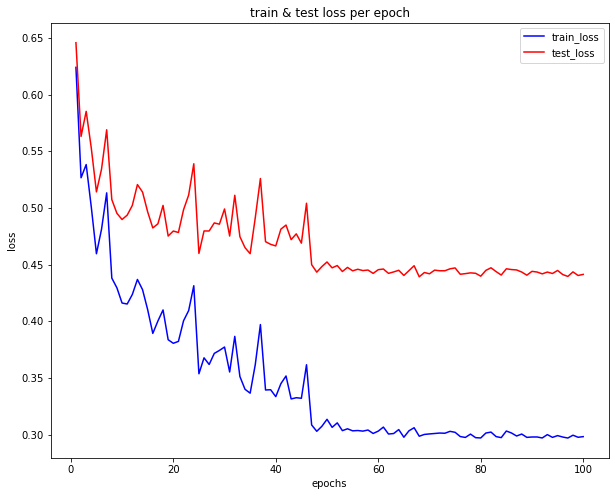

In [14]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_loss, 'b-', label='train_loss')
plt.plot(range(1, 101), test_loss, 'r-', label='test_loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train & test loss per epoch')
plt.legend()

plt.show()

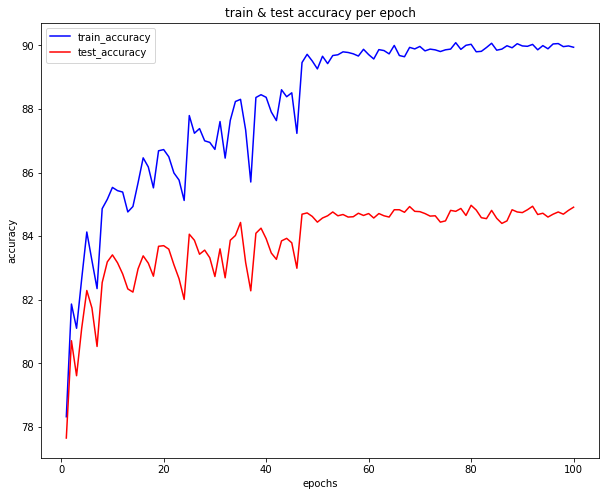

In [15]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_accuracy, 'b-', label='train_accuracy')
plt.plot(range(1, 101), test_accuracy, 'r-', label='test_accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('train & test accuracy per epoch')
plt.legend()

plt.show()

In [16]:
print(f'Best epoch: {best_epoch}')
print(f'Train: accuracy: {best_train_accuracy:>0.1f}%, avg loss: {best_train_loss:>8f}')
print(f'Test: accuracy: {best_test_accuracy:>0.1f}%, avg loss: {best_test_loss:>8f}')

Best epoch: 80
Train: accuracy: 90.0%, avg loss: 0.296999
Test: accuracy: 85.0%, avg loss: 0.439731


## 5.4 Model metrics

In [17]:
print(f'Train:\n{classification_report(best_train_y, best_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(best_test_y, best_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.92      0.90      0.91      5000
  automobile       0.94      0.95      0.95      5000
        bird       0.88      0.86      0.87      5000
         cat       0.82      0.83      0.82      5000
        deer       0.86      0.88      0.87      5000
         dog       0.88      0.86      0.87      5000
        frog       0.91      0.93      0.92      5000
       horse       0.92      0.90      0.91      5000
        ship       0.93      0.95      0.94      5000
       truck       0.95      0.93      0.94      5000

    accuracy                           0.90     50000
   macro avg       0.90      0.90      0.90     50000
weighted avg       0.90      0.90      0.90     50000

Test:
              precision    recall  f1-score   support

    airplane       0.85      0.85      0.85      1000
  automobile       0.90      0.91      0.90      1000
        bird       0.80      0.81      0.80      1000
         ca

<AxesSubplot:>

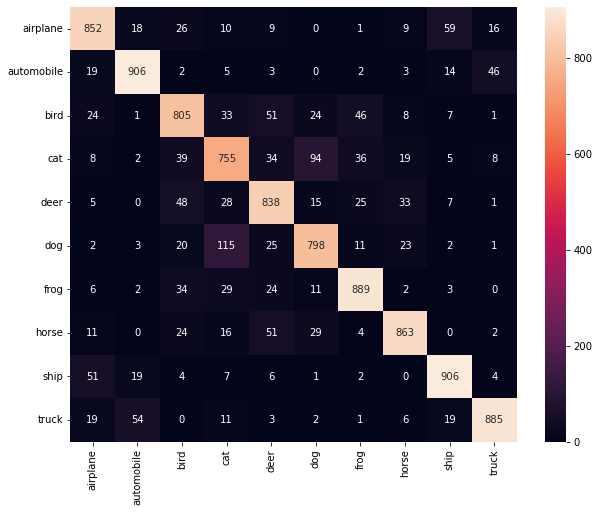

In [18]:
cm = confusion_matrix(best_test_y, best_test_pred)
sns.heatmap(cm, annot=True, fmt='', xticklabels=target_names, yticklabels=target_names, ax=plt.subplots(figsize=(10,8))[1])

## 5.5 Save model

In [19]:
torch.save(best_model_state_dict, '../saved-model/resnet50-weights.pth')